# Run Galfit on 3DHST galaxies
- 11/09/2020: Updated to use galfit_helpers.py module

### Load modules

In [1]:
from __future__ import division
import sys
sys.path.insert(0,'/data/emiln/XLSSC122_GalPops/Analysis/Modules')
from GalfitPyWrap import galfitwrap as gf
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.io import fits, ascii
from astropy.table import Table, hstack, join
import pickle
import fnmatch
import multiprocessing as mp
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import galfit_helpers as gfh

### Load 3DHST galaxy catalog

In [3]:
DHST_cat_root = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Products/catalogs/'
DHST_cat_filename = DHST_cat_root+'cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst.v4.1.cat'
# full_df = gfh.load_3DHST_galaxy_catalog(DHST_cat_filename, mag='F140W',magthresh=None, overwrite=False, verbose=True,goodfit=False)
full_df = gfh.load_3DHST_galaxy_catalog(DHST_cat_filename, mag='F140W',magthresh=30, overwrite=False, verbose=True,goodfit=False)
z2_filtered_df = gfh.load_3DHST_galaxy_catalog(DHST_cat_filename,  mag='F140W', magthresh=24, z=2.00, z_thresh=0.1, overwrite=False, verbose=True, goodfit=True) 

Checking if catalog exists at /data/emiln/XLSSC122_GalPops/Data/3DHST/Products/catalogs/magthresh30.csv
Catalog already exists, returning DataFrame
Checking if catalog exists at /data/emiln/XLSSC122_GalPops/Data/3DHST/Products/catalogs/magthresh24_z2.0_zthresh0.1.csv
Catalog already exists, returning DataFrame


In [4]:
print(len(z2_filtered_df))

136


### Set Galfit parameters

In [5]:
# fit_df = filtered_df[0:4]
fit_df = z2_filtered_df
df_name = '3DHST_z2_full'
psf_root = '/data/emiln/XLSSC122_GalPops/Data/3DHST/Products/PSF/'
# psf_file = psf_root+'cosmos_3dhst.v4.0.F140W_psf.fits' # Filename causes galfit to seg fault
psf_file = psf_root+'F140W_PSF.fits'
PSFf = 1 
convbox='64 64'
image_width = 400 # 200 for mag<23 objects, 400 for z2 objects
timeout=5*60
verbose=True
width=10
HLRwidth=5 # Cutout width = 2*HLwidth
PA_INIT = 45
AR_INIT = 0.5
ZP = 26.465 # https://iopscience.iop.org/article/10.1088/0067-0049/214/2/24/pdf page 13
# ZP = 25
# page 20 --> All cataloged fluxes are normalized to AB zero point = 25
MAG_INIT = 21
fitMagnitude = True
neighbourMagThresh=3
DYNMAG = True
sky='Default'
sky_INIT=0.00001
sigma_file = '/sigma_rms_meanexp_cps.fits'
data_file = '/data_cps.fits'
constraint_file = 'galfit_constr.txt' # Matches van der wel 2012 constraints
# constr_file = 'none'
badmask='none'
save_name = None

In [6]:
params = {
    'survey':'3DHST',
    'fit_df':fit_df, # Dataframe with objects to be fit
    'full_df':full_df, # Unfiltered source catalog used for fitting neighbours
    'width':width, # Fitting region width in pixels
    'HLRwidth':HLRwidth, # Fitting region width in # of HLR
    'sigma_file':sigma_file, # Filename of sigma maps for sources
    'data_file':data_file, # Filename for data cutouts for each source
    'PSF_file':psf_file, # File_name of PSF to be used
    'usePSF':True, # Use PSF in fitting?
    'timeout':timeout, # Max runtime per object in seconds
    'PSFf':PSFf, # Fine sampling factor
    'verbose':verbose, # Verbose mode
    'PA_INIT':PA_INIT, # Initial position angle
    'AR_INIT':AR_INIT, # Initial axis ratio
    'MAG_INIT':MAG_INIT, # Initial magnitude
    'convbox':convbox, # Region to convolve PSF with in pixels (i.e. '100 100')
    'ZP':ZP, # Zeropoint 
    'constraint_file':constraint_file, # Galfit constraint filename
    'image_width':image_width, # Size of data+sigma images being used (200 for COSMOS cutouts)
    'useDYNMAG':DYNMAG, # Initialize magnitudes from catalog?
    'badmask':badmask, # filename for bad pixel mask
    'fitMagnitude':fitMagnitude, # Fit magnitudes?
    'sky':sky, # Sky fitting mode for galfit (i.e. 'default')
    'sky_INIT':sky_INIT, # Initial sky level
    'neighbourMagThresh':neighbourMagThresh, # Additional magnitude threshhold to fit neighbours (i.e. 3 -> only neighbours with mag < source_mag+3 are fit)
    'df_name': df_name, # Descriptive name of catalog being fit
    'save_name':save_name # Filename to save results to, overrides default
}

In [8]:
new_df, savename = gfh.run_galfit_parallel(params,**params) # Feeds in unwrapped params as well as a copy to be passed as kwargs to sub functions

ersic'}, {'2_YC': '[400.0000]', '2_SKY': '-8.042e-03 +/- 1.595e-03', '2_XC': '[400.0000]', '2_DSDX': '[0.000e+00]', '2_DSDY': '[0.000e+00]', 'COMP_2': 'sky'}]
['1.0387']
['0.5736']
['21.7709']
['0.0958']
['0.6418']
['0.0377']
['-8.042e-03']
['1.595e-03']
ID 21806 len(n_val)>1 True
***3DHST***
Initializing 22865 with F140W Kron magnitude: 23.84
ID 22865
RA: 150.10871887
DEC: 2.4121778
Initial X: 7856.3
Initial Y: 21872.8
Cutout X: 400
Cutout Y: 400
Cutout width: 400
Cutoutwidth (pixels) for ID 22865 : 32
Cutoutwidth (arcsec) for ID 22865 : 1.92
Bounds: [384, 416, 384, 416]
0 NEIGHBOURS FOUND
Adding additional model components for neighbours...
Using PSF
Running galfit from CWD: /data/emiln/XLSSC122_GalPops/Data/Products/3DHST/galfit_results/22865
1_XC 400.1918 +/- 0.0704
1_YC 400.7726 +/- 0.0642
1_MAG 23.6261 +/- 0.1297
1_RE 2.6668 +/- 0.5478
1_N 4.1964 +/- 1.7299
1_AR 0.4855 +/- 0.0624
1_PA 46.7534 +/- 4.5400
2_XC [400.0000]
2_YC [400.0000]
2_SKY -4.249e-03 +/- 6.666e-04
2_DSDX [0.000e

### Validate results

In [9]:
new_df

,ID,ra,dec,re,re_err,ar,ar_err,n,n_err,mag,mag_err,sky,sky_err,chi2nu,ErrorValue
0,691,150.104736,2.187411,3.388400,0.2475,0.3654,0.0517,1.9423,0.5100,23.8350,0.0482,-0.002535,0.000334,0.176159,0
1,2140,150.147583,2.201060,6.811900,0.6494,0.5842,0.0402,1.0652,0.1661,23.6125,0.0718,-0.006408,0.000320,0.105534,0
2,2331,150.138916,2.202856,4.379200,0.2601,0.3908,0.0324,1.5878,0.2620,23.6156,0.0427,-0.002238,0.000289,0.158887,0
3,2712,150.138916,2.206575,2.346400,0.1619,0.6385,0.0553,1.5430,0.3921,23.7896,0.0315,-0.004378,0.000384,0.164614,0
4,2716,150.177567,2.208040,13.114500,0.3242,0.1926,0.0049,1.4314,0.0600,22.0050,0.0148,-0.002915,0.000167,0.126126,0
5,2816,150.141052,2.208472,4.105600,0.0510,0.2629,0.0067,1.6721,0.0702,21.7114,0.0059,-0.000812,0.000343,0.151182,0
6,2839,150.176773,2.207880,2.651100,1.3502,0.6280,0.0995,6.4928,4.5389,23.4541,0.2684,-0.001864,0.000816,0.148460,0
7,3285,150.109985,2.212173,1.729400,0.1924,0.3991,0.0602,4.8540,1.6818,23.4281,0.0724,-0.003519,0.000477,0.151586,0
8,3350,150.156952,2.212882,4.775100,0.1371,0.2795,0.0151,0.7796,0.1005,23.6894,0.0179,-0.002358,0.000207,0.160179,0
9,3576,150.122284,2.214931,37.230600,59.4225,0.5313,0.0441,9.2298,5.0104,22.4338,0.7293,-0.004288,0.000615,0.141499,0


    ID          ra       dec      re  re_err      ar  ar_err       n  n_err  \
0  691  150.104736  2.187411  3.3884  0.2475  0.3654  0.0517  1.9423   0.51   

      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
0  23.835   0.0482 -0.002535  0.000334  0.176159           0  


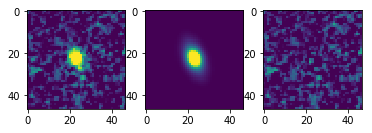

     ID          ra      dec      re  re_err      ar  ar_err       n   n_err  \
1  2140  150.147583  2.20106  6.8119  0.6494  0.5842  0.0402  1.0652  0.1661   

       mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
1  23.6125   0.0718 -0.006408  0.00032  0.105534           0  


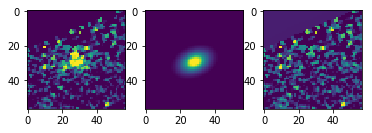

     ID          ra       dec      re  re_err      ar  ar_err       n  n_err  \
2  2331  150.138916  2.202856  4.3792  0.2601  0.3908  0.0324  1.5878  0.262   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
2  23.6156   0.0427 -0.002238  0.000289  0.158887           0  


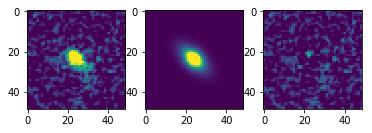

     ID          ra       dec      re  re_err      ar  ar_err      n   n_err  \
3  2712  150.138916  2.206575  2.3464  0.1619  0.6385  0.0553  1.543  0.3921   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
3  23.7896   0.0315 -0.004378  0.000384  0.164614           0  


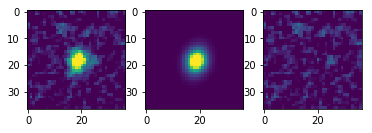

     ID          ra      dec       re  re_err      ar  ar_err       n  n_err  \
4  2716  150.177567  2.20804  13.1145  0.3242  0.1926  0.0049  1.4314   0.06   

      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
4  22.005   0.0148 -0.002915  0.000167  0.126126           0  


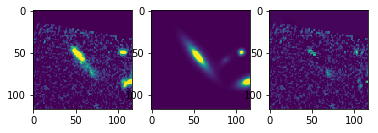

     ID          ra       dec      re  re_err      ar  ar_err       n   n_err  \
5  2816  150.141052  2.208472  4.1056   0.051  0.2629  0.0067  1.6721  0.0702   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
5  21.7114   0.0059 -0.000812  0.000343  0.151182           0  


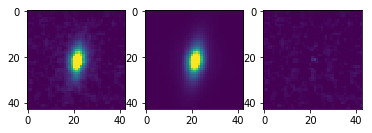

     ID          ra      dec      re  re_err     ar  ar_err       n   n_err  \
6  2839  150.176773  2.20788  2.6511  1.3502  0.628  0.0995  6.4928  4.5389   

       mag  mag_err       sky   sky_err   chi2nu  ErrorValue  
6  23.4541   0.2684 -0.001864  0.000815  0.14846           0  


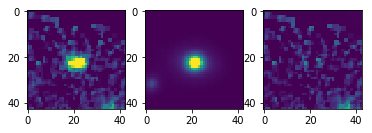

     ID          ra       dec      re  re_err      ar  ar_err      n   n_err  \
7  3285  150.109985  2.212173  1.7294  0.1924  0.3991  0.0602  4.854  1.6818   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
7  23.4281   0.0724 -0.003519  0.000477  0.151586           0  


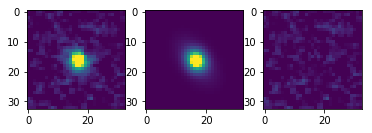

In [12]:
# Plot fits by ID
for ID in fit_df['ID'][0:8]:
    gfh.plot_by_ID(ID,save_name=savename,survey='3DHST')